In [1]:
import pandas as pd
import seaborn as sns
import datetime
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

In [2]:
data = pd.read_csv("11-18-2014-330.csv",header=None)

In [3]:
data.columns = ['id','time','p1_amp','p1_filter','p2_amp','p2_filter','label']

In [4]:
data['id']=data['id'] - min(data['id']) + 1

### Assign ids to each speech group

A speech group is defined as a continuous length of speech spoken by an induvidual.It is less than that of a turn and its broken by singular pauses

In [5]:
# Detect when there is a change from speech to no speech
data['p1_change'] = (data['p1_filter'] == 1.0) & (data['p1_filter'].shift() == 0.0)
data['p1_change'] = (data['p1_filter'] == 0.0) & (data['p1_filter'].shift() == 1.0)

In [6]:
# Explore a place where the shift occcours
data.iloc[22925:22929,:].head()

,id,time,p1_amp,p1_filter,p2_amp,p2_filter,label,p1_change
22925,1,2.865625,0.010721,1.0,-0.001084,0.0,A,False
22926,1,2.865750,0.014171,1.0,-0.000050,0.0,A,False
22927,1,2.865875,0.002427,0.0,0.001553,0.0,A,True
22928,1,2.866000,0.006369,0.0,0.001624,0.0,A,False


In [7]:
# Get Index values of P1 so that they could be given a single Id number
p1_index_values = data[data['p1_change'] == True].index.values
p1_index_values = np.insert(p1_index_values,0,0)

In [8]:
#  Set all values to -1.
data['p1_speech_grps'] = -1

In [10]:
# Assign ids
for i in range(len(p1_index_values)-1):
    data.at[p1_index_values[i]:p1_index_values[i+1],"p1_speech_grps"] = i+1
    

In [11]:
data[data['p1_speech_grps']==6].head()

,id,time,p1_amp,p1_filter,p2_amp,p2_filter,label,p1_change,p1_speech_grps
103842,1,12.980250,-0.008520,0.0,0.002088,0.0,A,True,6
103843,1,12.980375,-0.013543,0.0,0.005345,0.0,A,False,6
103844,1,12.980500,-0.014190,0.0,-0.002011,0.0,A,False,6
103845,1,12.980625,-0.011404,0.0,-0.005630,0.0,A,False,6
103846,1,12.980750,-0.002389,0.0,-0.002994,0.0,A,False,6


### Outlier Detection 

The outliers were detected using Median average Deviation. This was just to perform a sanity check on the dataset

In [14]:
output_data = data.groupby('p1_speech_grps',as_index = False).agg({
    'p1_amp':'var',
    'time' : lambda x: max(x) - min(x)
})

In [43]:
from astropy.stats import median_absolute_deviation
import statistics
mad = median_absolute_deviation(output_data.time)
deviations = abs(output_data.time - statistics.median(output_data.time))/mad


In [49]:
outliers = deviations[deviations > 10].index

In [50]:
outliers

Int64Index([  6,  34,  47,  80, 116, 118, 126, 135, 156, 166, 186, 193, 217,
            236, 253, 270, 277, 279, 288, 295, 300, 374, 378, 382, 393, 398,
            410, 432],
           dtype='int64')

In [94]:
# Calculate the total duration of every group
p1_speech_groups = data.loc[data['p1_speech_grps'].isin(outliers)].groupby(['p1_speech_grps','id']).agg({
    'time': [min,max]
}).head(7)

### Noise and its variations across length

We wanted to explore if the segments that have less variance tend to be shorter. From the exploratory analysis, it was not the case

  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: [True | False] 
  axes: an :class:`~matplotlib.axes.Axes` instance 
  backgroundcolor: any matplotlib color 
  bbox: FancyBboxPatch prop dict 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color: any matplotlib color 
  contains: a callable function 
  family or fontfamily or fontname or name: [FONTNAME | 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace' ] 
  figure: a :class:`matplotlib.figure.Figure` instance 
  fontproperties or font_properties: a :class:`matplotlib.font_manager.FontProperties` instance 
  gid: an id string 
  horizontalalignment or ha: [ 'center' | 'right' | 'left' ] 
  label: string or anything printable with '%s' conversion. 
  linespacing: float (multiple of font size) 
  multialignment: 

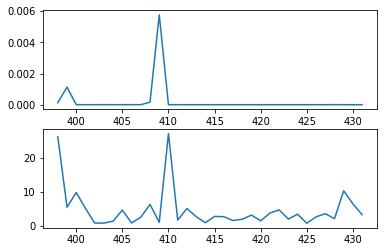

In [71]:
ax1 = plt.subplot(211)
plt.plot(output_data[id_23_values[0]:id_23_values[len(id_23_values)-1]][['p1_speech_grps']],output_data[id_23_values[0]:id_23_values[len(id_23_values)-1]][['p1_amp']])
plt.setp(ax1.get_xticklabels())

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(output_data[id_23_values[0]:id_23_values[len(id_23_values)-1]][['p1_speech_grps']],output_data[id_23_values[0]:id_23_values[len(id_23_values)-1]][['time']])

# make these tick labels invisible
plt.setp(ax2.get_xticklabels())

plt.show()

## Group Variance

It is a writing activity, students don't talk most of the time.  Hence a 15% Conservative match is taken

In [114]:
group_var = data.groupby('p1_speech_grps',as_index = False)['p1_amp'].agg({
    'p1_amp': lambda x: x.quantile(0.75) - x.quantile(0.25)
})
group_var.head()

,p1_speech_grps,p1_amp
0,-1,0.002324
1,1,0.004513
2,2,0.006304
3,3,0.008149
4,4,0.006573


In [119]:
np.percentile(group_var.p1_amp,20)

0.0013998655747855084

## Sample with background noise
The id=23 is a sample that has lots of variations with background noise. These variations 

In [84]:
print("Id Values of 23: ",id_23_values[0],id_23_values[len(id_23_values)-1])

Id Values of 23:  398 432


In [120]:
data.head()

,id,time,p1_amp,p1_filter,p2_amp,p2_filter,label,p1_change,p1_speech_grps
0,1,0.000000,-0.000477,1.0,0.0,1.0,A,False,1
1,1,0.000125,-0.000813,1.0,0.0,1.0,A,False,1
2,1,0.000250,0.000190,1.0,0.0,1.0,A,False,1
3,1,0.000375,-0.000927,1.0,0.0,1.0,A,False,1
4,1,0.000500,-0.000449,1.0,0.0,1.0,A,False,1


In [116]:
(group_var.loc[398:432,"p1_amp"] < np.percentile(group_var.p1_amp,20)).value_counts()

False    20
True     15
Name: p1_amp, dtype: int64

Group variance was effective in removing false postives. But I believe this metric may not be very suitable for our work since I could justify the cutoff at this range.

## Group Range 

An evaluation of group range is made for every group.



### Step 1: Calculate Median absolute deviation for every value to check for Outliers and Remove them

In [13]:
from astropy.stats import median_absolute_deviation
import statistics
#abs(x-  statistics.median(x)) / median_absolute_deviation(x)

group_mad = data.groupby('p1_speech_grps',as_index = False)['p1_amp'].agg({
    'p1_amp_grp_mad': lambda x: median_absolute_deviation(x), 
    'p1_grp_med': lambda x: statistics.median(x)
})

group_mad.head()

,p1_speech_grps,p1_amp_grp_mad,p1_grp_med
0,-1,0.001164,-0.000256
1,1,0.002250,-0.000320
2,2,0.003146,-0.000387
3,3,0.004070,-0.000378
4,4,0.003279,-0.000294


In [14]:
data.head()

,id,time,p1_amp,p1_filter,p2_amp,p2_filter,label,p1_change,p1_speech_grps
0,1,0.000000,-0.000477,1.0,0.0,1.0,A,False,1
1,1,0.000125,-0.000813,1.0,0.0,1.0,A,False,1
2,1,0.000250,0.000190,1.0,0.0,1.0,A,False,1
3,1,0.000375,-0.000927,1.0,0.0,1.0,A,False,1
4,1,0.000500,-0.000449,1.0,0.0,1.0,A,False,1


In [15]:
data_mad = pd.merge(data,group_mad,on="p1_speech_grps",how="inner")

In [16]:
data_mad.head()

,id,time,p1_amp,p1_filter,p2_amp,p2_filter,label,p1_change,p1_speech_grps,p1_amp_grp_mad,p1_grp_med
0,1,0.000000,-0.000477,1.0,0.0,1.0,A,False,1,0.00225,-0.00032
1,1,0.000125,-0.000813,1.0,0.0,1.0,A,False,1,0.00225,-0.00032
2,1,0.000250,0.000190,1.0,0.0,1.0,A,False,1,0.00225,-0.00032
3,1,0.000375,-0.000927,1.0,0.0,1.0,A,False,1,0.00225,-0.00032
4,1,0.000500,-0.000449,1.0,0.0,1.0,A,False,1,0.00225,-0.00032


In [17]:
data_mad['deviation'] = abs((data_mad.p1_amp - data_mad.p1_grp_med ) / data_mad.p1_amp_grp_mad)

In [18]:
deviations = sorted(data_mad['deviation'])

In [19]:
import matplotlib.pyplot as plt
deviations_df = pd.Series(deviations)


In [20]:
deviations_df = deviations_df.astype("int")

In [21]:
deviations_df.value_counts().tail(10)

1080    1
1079    1
1078    1
1077    1
1076    1
976     1
1068    1
979     1
1064    1
1274    1
dtype: int64

In [22]:
deviations_df.value_counts().head(12)

0     8229989
1     3618460
2     1554848
3      733368
4      412736
5      270107
6      193948
7      147406
8      117122
9       95783
10      79980
11      67722
dtype: int64

### Step 2: Remove Outliers from data frames

As a rule of Thumb, anything above 2.5 to 3.0 are considered to be outliers. We remove them 

In [25]:
data_mad.head()

,id,time,p1_amp,p1_filter,p2_amp,p2_filter,label,p1_change,p1_speech_grps,p1_amp_grp_mad,p1_grp_med,deviation
0,1,0.000000,-0.000477,1.0,0.0,1.0,A,False,1,0.00225,-0.00032,0.069582
1,1,0.000125,-0.000813,1.0,0.0,1.0,A,False,1,0.00225,-0.00032,0.218751
2,1,0.000250,0.000190,1.0,0.0,1.0,A,False,1,0.00225,-0.00032,0.226998
3,1,0.000375,-0.000927,1.0,0.0,1.0,A,False,1,0.00225,-0.00032,0.269547
4,1,0.000500,-0.000449,1.0,0.0,1.0,A,False,1,0.00225,-0.00032,0.056954


In [26]:
data_cleaned  = data_mad.loc[data_mad['deviation'] < 3]

In [27]:
data_cleaned.shape

(13403297, 12)

In [28]:
data_mad.shape

(16460209, 12)

About 18% of the data were outliers

## Step 3. Finding Range

In [31]:
data_range = data_cleaned.groupby('p1_speech_grps',as_index = False)['p1_amp'].agg({
    'range': lambda x : max(x) - min(x)
})

In [35]:
data_range = data_range * 1e3

In [36]:
data_range.head()

,p1_speech_grps,range
0,-1000.0,6.969099
1,1000.0,13.501030
2,2000.0,18.858873
3,3000.0,24.415232
4,4000.0,19.651535


In [37]:
data_range.range.quantile(0.10)

3.7938583875074983

In [40]:
(data_range.loc[398:432,"range"] < np.percentile(data_range.range,20)).value_counts()

False    20
True     15
Name: range, dtype: int64

As these did not improve the results at all, We cannot say how many occurences of these speech signal would happen for every sound signal. Hence it would be very hard to determine them with percentile values. Hence, a cutoff value has to be emprically determined. 

## Emprical Determination of Range Cutoff Value

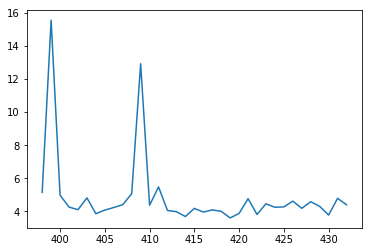

In [41]:
plt.plot(data_range.loc[398:432,"range"])

In [85]:
time_range.loc[398:432,]

,p1_speech_grps,range,segment_start,segment_end
398,398,5.145618,0.000000,26.120750
399,399,15.551724,6.812625,12.337625
400,400,4.979284,12.337750,22.166000
401,401,4.260590,22.166125,27.341375
402,402,4.104622,27.341500,28.224250
403,403,4.815313,28.224375,29.098375
404,404,3.860246,29.098500,30.543875
405,405,4.079401,30.544000,35.222250
406,406,4.235278,35.222375,36.142000
407,407,4.407035,36.142125,38.752625


Compute Start and Stop position of Speech Groups for every id

In [83]:
segment_groups = data.groupby('id')['p1_speech_grps'].agg({
    'segment_start': lambda x : min(x),
    'segment_end' : lambda x : max(x)
})

/home/sreeaurovindh/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
time_groups = data.groupby('p1_speech_grps',as_index= False)['time'].agg({
    'segment_start': lambda x : min(x),
    'segment_end' : lambda x : max(x)
})

time_groups.head()

,p1_speech_grps,segment_start,segment_end
0,-1,67.668750,69.194625
1,1,0.000000,2.865750
2,2,2.865875,5.429375
3,3,5.429500,9.547625
4,4,9.547750,11.565500


In [71]:
data_range.head()

,p1_speech_grps,range
0,-1,6.969099
1,1,13.501030
2,2,18.858873
3,3,24.415232
4,4,19.651535


In [79]:
time_range = pd.merge(data_range,time_groups,on="p1_speech_grps",how="inner")

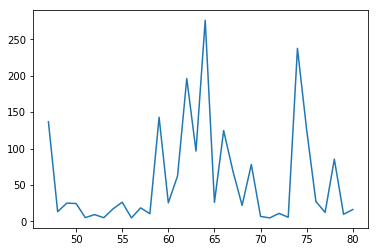

In [80]:
plt.plot(time_range.loc[47:80,"range"])

In [ ]:
time_range.loc[47:80,]

In [63]:
data.head()

,id,time,p1_amp,p1_filter,p2_amp,p2_filter,label,p1_change,p1_speech_grps
0,1,0.000000,-0.000477,1.0,0.0,1.0,A,False,1
1,1,0.000125,-0.000813,1.0,0.0,1.0,A,False,1
2,1,0.000250,0.000190,1.0,0.0,1.0,A,False,1
3,1,0.000375,-0.000927,1.0,0.0,1.0,A,False,1
4,1,0.000500,-0.000449,1.0,0.0,1.0,A,False,1


In [84]:
segment_groups

,segment_start,segment_end
id,,
1,1,47
2,47,80
3,80,116
4,116,118
5,118,126
6,126,135
7,135,156
8,156,166
9,166,186


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_res, y_res)
model = SelectFromModel(lsvc, prefit=True)

X_new = model.transform(X_res)

print(X_res.shape,y_res.shape)
X_test[0]